In [1]:
from torchvision import models
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from random import shuffle
import numpy as np
import os
from PIL import Image
from torchvision import transforms
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.utils.data as data_utils

In [2]:
data_path = "data/data_first_25"

In [3]:
test_transform = transforms.Compose(
    [transforms.Resize(256),  # 1. Resize smallest side to 256.
     transforms.CenterCrop(224), # 2. Crop center square of 224x224 pixels.
     transforms.ToTensor(), # 3. Convert to pytorch tensor.
     transforms.Normalize(mean = [0.485, 0.456, 0.406],  # normalize.
                          std = [0.229, 0.224, 0.225])
    ])

In [4]:
def get_img_list(cat,d1):
    ret = list()
    for frame in os.listdir(data_path + '/{}/{}'.format(cat,d1)):
        img_pil = Image.open(data_path + '/{}/{}/{}'.format(cat,d1,frame))
        input_img = test_transform(img_pil)
        ret.append(input_img)
    return ret

# This sets the first 7 videos as val and the rest as train, which are the official train/test splits for UCF101
# https://www.crcv.ucf.edu/data/UCF101.php
def createTrainAndValSet(categories):
    category_options = sorted(os.listdir(data_path))
    category_names = category_options[:categories]
    train_set = []
    val_set = []
    i=0
    for cat in category_names:
        print(cat)
        for d1 in os.listdir(data_path + '/{}'.format(cat)):
            img_list = get_img_list(cat,d1)
            if int(d1[1:3]) >= 8:
                train_set.append((img_list,i))
            else:
                val_set.append((img_list,i))
        i+=1
    print("train_len", len(train_set), "val_len", len(val_set))
    return train_set,val_set

In [5]:
class AverageModel(nn.Module):
    def __init__(self, output_size=5, batchSize=3):
        super(AverageModel, self).__init__()

        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.output_size = output_size
        self.batchSize = batchSize
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, output_size)
        
    def forward(self, x_3d):
        result = torch.zeros((batchSize,self.output_size)).cuda()
        for frame in range(x_3d.size(1)):
            x = self.resnet(x_3d[:, frame, :, :, :])  # ResNet
            x = x.view(x.size(0), -1)             # flatten output of conv

            # FC layers
            x = self.fc1(x)
          
            result += x
        result /= x_3d.size(1)
        return result

In [6]:
# No longer used, using DataLoader instead of this
def load_data(dataset, batchSize, shuffle_data=True):
    train_loader = []
    i = 0
    if shuffle_data:
        shuffle(dataset)
    while i + batchSize < len(dataset):
        batch_inputs = []
        batch_labels = []
        for j in range(batchSize):
            batch_inputs.append(torch.stack(dataset[i + j][0]))
            batch_labels.append(torch.tensor([dataset[i + j][1]]))
        
        batch_inputs = torch.stack(batch_inputs)
        batch_labels = torch.stack(batch_labels).squeeze()
        train_loader.append((batch_inputs, batch_labels))
        i += batchSize
    return train_loader

In [7]:
from random import shuffle

train_accuracies = []; train_losses = [];
val_accuracies = []; val_losses = [];

def train_model(model, loss_fn, optimizer, batchSize, epochs):
    model = model.cuda()
    loss_fn = loss_fn.cuda()
    
    train_loader = DataLoader(train_set, batch_size=batchSize, drop_last=True, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batchSize, drop_last=True, shuffle=True)
    
    print("training...")
    for epoch in range(epochs):
        correct = 0
        cum_loss = 0

        model.train()
        for (i, (inputs, target)) in enumerate(train_loader):
            frame_list = torch.stack(inputs).transpose(0, 1).cuda()
            
            scores = model(frame_list)            
            loss = loss_fn(scores, torch.tensor(np.array(target),dtype=torch.long).cuda())

            target = target.cuda()
            max_scores, max_labels = scores.max(1)
            correct += (max_labels == target).sum().item()
            cum_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i + 1) % 10 == 0:
                print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                    (epoch, i + 1, cum_loss / (i + 1), correct / ((i + 1) * batchSize)))

        train_accuracies.append(correct / ((i + 1) * batchSize))
        train_losses.append(cum_loss / (i + 1))   
        
        correct = 0
        cum_loss = 0
        model.eval()
        for (i, (inputs, target)) in enumerate(val_loader):
            frame_list = torch.stack(inputs).transpose(0, 1).cuda()

            scores = model(frame_list)
            loss = loss_fn(scores, torch.tensor(np.array(target),dtype=torch.long).cuda())

            target = target.cuda()
            max_scores, max_labels = scores.max(1)
            correct += (max_labels == target).sum().item()
            cum_loss += loss.item()
            
        print('Validation-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
               (epoch, i + 1, cum_loss / (i + 1), correct / ((i + 1) * batchSize)))
        
        val_accuracies.append(correct / ((i + 1) * batchSize))
        val_losses.append(cum_loss / (i + 1))

In [8]:
categories = 10

train_set, val_set = createTrainAndValSet(categories)

ApplyEyeMakeup
ApplyLipstick
Archery
BabyCrawling
BalanceBeam
BandMarching
BaseballPitch
Basketball
BasketballDunk
BenchPress
train_len 985 val_len 389


In [10]:
learning_rate = 5e-4
momentum = 0.5
weight_decay = 1e-4
batchSize= 48
epochs = 20

my_model = AverageModel(output_size=categories, batchSize=batchSize)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(my_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

train_model(my_model, loss_fn, optimizer, batchSize, epochs)

training...
Train-epoch 0. Iteration 00010, Avg-Loss: 2.3992, Accuracy: 0.1125
Train-epoch 0. Iteration 00020, Avg-Loss: 2.3257, Accuracy: 0.1635
Validation-epoch 0. Iteration 00008, Avg-Loss: 2.2068, Accuracy: 0.1927
Train-epoch 1. Iteration 00010, Avg-Loss: 2.1153, Accuracy: 0.3021
Train-epoch 1. Iteration 00020, Avg-Loss: 2.0808, Accuracy: 0.3177
Validation-epoch 1. Iteration 00008, Avg-Loss: 2.0402, Accuracy: 0.3359
Train-epoch 2. Iteration 00010, Avg-Loss: 1.9330, Accuracy: 0.4333
Train-epoch 2. Iteration 00020, Avg-Loss: 1.9005, Accuracy: 0.4562
Validation-epoch 2. Iteration 00008, Avg-Loss: 1.8728, Accuracy: 0.4453
Train-epoch 3. Iteration 00010, Avg-Loss: 1.7944, Accuracy: 0.5312
Train-epoch 3. Iteration 00020, Avg-Loss: 1.7385, Accuracy: 0.5823
Validation-epoch 3. Iteration 00008, Avg-Loss: 1.7404, Accuracy: 0.5208
Train-epoch 4. Iteration 00010, Avg-Loss: 1.6206, Accuracy: 0.6354
Train-epoch 4. Iteration 00020, Avg-Loss: 1.6014, Accuracy: 0.6500
Validation-epoch 4. Iteration 

Data: 10 non-consecutive frames, equally separated throughout video
Categories: 10
Model: Average
Loss Function: CrossEntropyLoss
Optimizer: SGD
Learning Rate: 0.0005
Momentum: 0.5
Weight Decay: 0.0001


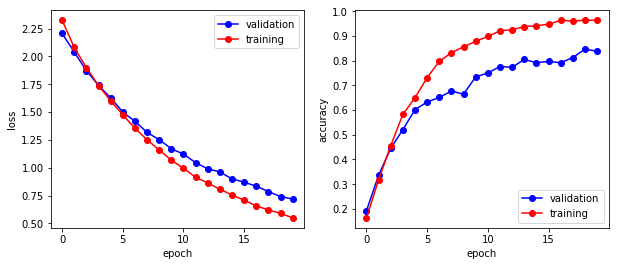

In [11]:
print("Data: 10 non-consecutive frames, equally separated throughout video")
print("Categories:", categories)
print("Model: Average")
print("Loss Function: CrossEntropyLoss")
print("Optimizer: SGD")
print("Learning Rate:", learning_rate)
print("Momentum:", momentum)
print("Weight Decay:", weight_decay)

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_losses, 'bo-', label = 'val-loss')
plt.plot(train_losses, 'ro-', label = 'train-loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, 'bo-', label = 'val-acc')
plt.plot(train_accuracies, 'ro-', label = 'train-acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='lower right')
plt.show()